# US Name
Model estimate Estimate sign of effect


# Description

None

# Metadata

- Key: 242_esg_metadata 
- Epic: Models
- US: Estimate sign of effect
- Task tag: #draft, #polymer, #sign-of-effect
- Analytics reports: 

# Input

## Table/file

**Name**

None

**Github**

- https://github.com/thomaspernet/esg_metadata/blob/master/02_data_analysis/01_model_train_evaluate/01_sign_of_effect/00_sign_of_effect_classification.md



# Connexion server

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
#import seaborn as sns
import os, shutil, json
import sys
import janitor

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-2'
bucket = 'datalake-london'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

In [5]:
db = 'esg'
table = 'meta_analysis_esg_cfp'

In [6]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)',
                         'varchar(3)',
                        'varchar(14)', 'varchar(11)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )

In [7]:
download_data = True
filename = 'df_{}'.format(table)
full_path_filename = 'SQL_OUTPUT_ATHENA/CSV/{}.csv'.format(filename)
path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalog/temporary_local_data")
df_path = os.path.join(path_local, filename + '.csv')
if download_data:
    
    s3 = service_s3.connect_S3(client = client,
                          bucket = bucket, verbose = False)
    query = """
    WITH test as (
  SELECT 
    *, concat(environmental,  social, governance) as filters
  FROM {}.{} 
  WHERE 
    first_date_of_observations IS NOT NULL 
    and last_date_of_observations IS NOT NULL 
    and adjusted_model != 'TO_REMOVE' 
) 
SELECT 
  filters, to_remove, test.id, image, row_id_excel, row_id_google_spreadsheet,
       table_refer, incremental_id, paper_name, publication_name,
       rank, sjr, sjr_best_quartile, h_index, total_docs_2020,
       total_docs_3years, total_refs, total_cites_3years,
       citable_docs_3years, cites_doc_2years, country,
       publication_year, publication_type, cnrs_ranking, peer_reviewed,
       study_focused_on_social_environmental_behaviour, type_of_data,
       first_date_of_observations,mid_year, last_date_of_observations,
       windows, adjusted_model_name,
       adjusted_model, dependent, adjusted_dependent, independent,
       adjusted_independent, 
       social,
       environmental,
       governance,
       financial_crisis,
       kyoto,
       regions,
       study_focusing_on_developing_or_developed_countries,
       lag,
       interaction_term, quadratic_term, n, r2, beta,
       sign_of_effect,
       adjusted_t_value,
       adjusted_standard_error,
       target,
       p_value_significant,
       weight,
       nb_authors,
       reference_count,
       citation_count,
       cited_by_total,
       CASE WHEN is_open_access = TRUE THEN 'YES' ELSE 'NO' END AS is_open_access,
       total_paper,
       esg,
       pct_esg,
       paper_name,
       female,
       male,
       unknown,
       pct_female,
       region_journal,
       csr_20_categories,
       cfp_4_categories,
       CASE WHEN cluster_w_emb = '0.0' THEN 'CLUSTER_0'
       WHEN cluster_w_emb = '1.0' THEN 'CLUSTER_1'
       ELSE 'CLUSTER_2' END AS cluster_w_emb,
       sentiment,
       lenght,
       adj,
       noun,
       verb,
       size_abstract,
       pct_adj,
       pct_noun,
       pct_verb,
       CASE WHEN pct_female > 0 THEN 'YES' ELSE 'NO' END AS d_female,
       CASE WHEN 
       csr_20_categories ='MSCI' 
       -- csr_20_categories ='BLOOMBERG' OR 
       -- csr_20_categories ='THOMSON'
       THEN 'MSCI' ELSE 'NOT_MSCI' END AS providers
       
FROM 
  test 
  LEFT JOIN (
    SELECT 
      id, 
      COUNT(*) as weight 
    FROM 
      test 
    GROUP BY 
      id
  ) as c on test.id = c.id
  WHERE filters != 'TrueTrueTrue' and filters != 'FalseFalseFalse' and sjr IS NOT NULL

    """.format(db, table)
    try:
        df = (s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
                )
    except:
        pass
df.head(2)

,filters,to_remove,id,image,row_id_excel,row_id_google_spreadsheet,table_refer,incremental_id,paper_name,publication_name,rank,sjr,sjr_best_quartile,h_index,total_docs_2020,total_docs_3years,total_refs,total_cites_3years,citable_docs_3years,cites_doc_2years,country,publication_year,publication_type,cnrs_ranking,peer_reviewed,study_focused_on_social_environmental_behaviour,type_of_data,first_date_of_observations,mid_year,last_date_of_observations,windows,adjusted_model_name,adjusted_model,dependent,adjusted_dependent,independent,adjusted_independent,social,environmental,governance,financial_crisis,kyoto,regions,study_focusing_on_developing_or_developed_countries,lag,interaction_term,quadratic_term,n,r2,beta,sign_of_effect,adjusted_t_value,adjusted_standard_error,target,p_value_significant,weight,nb_authors,reference_count,citation_count,cited_by_total,is_open_access,total_paper,esg,pct_esg,paper_name.1,female,male,unknown,pct_female,region_journal,csr_20_categories,cfp_4_categories,cluster_w_emb,sentiment,lenght,adj,noun,verb,size_abstract,pct_adj,pct_noun,pct_verb,d_female,providers
0,NOYESNO,TO_KEEP,64,https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=479654123&range=B91,https://docs.google.com/spreadsheets/d/11A3l50yfiGxxRuyV-f3WV9Z-4DcsQLYW6XBl4a7U4bQ/edit#gid=18346659&range=B814,https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=899172650&range=B470,table 2,469,How Corporate Social Responsibility Engagement Strategy Moderates the CSR–Financial Performance Relationship,journal of management studies,347,4.398,Q1,184,95,160,7792,1265,147,6,United Kingdom,2012,Journal Article,1,YES,ENVIRONMENTAL SOCIAL AND GOVERNANCE,Panel data,1998,2003,2007,9,HAUSMAN–TAYLOR MODELLING,OTHER,ROA,ROA,CSR,CSR,YES,NO,NO,NO,YES,WORLDWIDE,WORLDWIDE,NO,NO,NO,1300.0,0.0,0.0,POSITIVE,1.0,0.0,SIGNIFICANT,10_PERCENT,2,3,303,1143,1743,NO,198,48,0.242424,How Corporate Social Responsibility Engagement Strategy Moderates the CSR–Financial Performance Relationship,2.0,1.0,0.0,0.666667,EUROPE,MSCI,Accounting based metrics,CLUSTER_2,POSITIVE,1.0,27.0,55.0,27.0,193.0,0.139896,0.284974,0.139896,YES,MSCI
1,NOYESNO,TO_KEEP,64,https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=479654123&range=B91,https://docs.google.com/spreadsheets/d/11A3l50yfiGxxRuyV-f3WV9Z-4DcsQLYW6XBl4a7U4bQ/edit#gid=18346659&range=B814,https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=899172650&range=B471,table 2,470,How Corporate Social Responsibility Engagement Strategy Moderates the CSR–Financial Performance Relationship,journal of management studies,347,4.398,Q1,184,95,160,7792,1265,147,6,United Kingdom,2012,Journal Article,1,YES,ENVIRONMENTAL SOCIAL AND GOVERNANCE,Panel data,1998,2003,2007,9,HAUSMAN–TAYLOR MODELLING,OTHER,ROA,ROA,CSR,CSR,YES,NO,NO,NO,YES,WORLDWIDE,WORLDWIDE,NO,YES,NO,1300.0,0.0,0.0,INSIGNIFICANT,0.0,0.0,NOT_SIGNIFICANT,INSIGNIFICANT,2,3,303,1143,1743,NO,198,48,0.242424,How Corporate Social Responsibility Engagement Strategy Moderates the CSR–Financial Performance Relationship,2.0,1.0,0.0,0.666667,EUROPE,MSCI,Accounting based metrics,CLUSTER_2,POSITIVE,1.0,27.0,55.0,27.0,193.0,0.139896,0.284974,0.139896,YES,MSCI


## CNRS ranking

- Reconstruct CNRS ranking from ground truth PDF

**Steps**

1. Use this link to download data : https://www.gate.cnrs.fr/spip.php?rubrique31&lang=fr
    - Select 2020 ranking: https://www.gate.cnrs.fr/IMG/pdf/categorisation37_liste_juin_2020-2.pdf
2. Use tabula to download table
3. Fetch the publication name from the main dataframe
4. Extract digits only from the CNRS ranking
5. When the publication is not in the CNRS, fill it with 5
6. Merge back main dataframe

In [8]:
#!sudo apt-get install openjdk-8-jre -Y

In [9]:
#!pip install tabula-py
import tabula
import requests

In [10]:
url = "https://www.gate.cnrs.fr/IMG/pdf/categorisation37_liste_juin_2020-2.pdf"
r = requests.get(url, allow_redirects=True)
open('categorisation37_liste_juin_2020-2.pdf', 'wb').write(r.content)

570452

In [11]:
list_tables = tabula.read_pdf('categorisation37_liste_juin_2020-2.pdf', pages='all')
list_list_tables= [list_tables[i].values.tolist() for i in range(0, len(list_tables)) if len(list_tables[i])>0]
df_cnrs = (
    pd.DataFrame([item for sublist in list_list_tables for item in sublist], columns = [
    "NAME","ISSN","DOMAINE","RANK"
])
    .assign(
        publication_name = lambda x:x['NAME'].str.lower()
    )
    .drop_duplicates()
)
df_cnrs.head()

WARNING: Got stderr: Oct 29, 2021 3:00:46 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'
Oct 29, 2021 3:00:46 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPS-ItalicMT'
Oct 29, 2021 3:00:46 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPS-BoldMT'
Oct 29, 2021 3:00:46 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'
Oct 29, 2021 3:00:46 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPS-ItalicMT'
Oct 29, 2021 3:00:46 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPS-BoldMT'
Oct 29, 2021 3:00:47 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'
Oct 29, 2021 3:00:47 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPS-ItalicMT'
Oct 29, 2021 3:00:47 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPS-BoldMT'
Oct 29, 2021 3:00:48 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPS-BoldItalicMT'
Oct 29, 2021 3:00:48 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'
Oct 29, 2021 3:00:48 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPS-ItalicMT'
Oct 29, 2021 3:00:48 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPS-BoldItalicMT'
Oct 29, 2021 3:00:48 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPS-BoldMT'
Oct 29, 2021 3:00:49 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPSMT'
Oct 29, 2021 3:00:49 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPS-ItalicMT'
Oct 29, 2021 3:00:49 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'TimesNewRomanPS-BoldMT'
Oct 29, 2021 3:00:49 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'Arial-BoldMT'
Oct 29, 2021 3:00:49 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'Arial-BoldItalicMT'
Oct 29, 2021 3:00:49 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'ArialMT'
Oct 29, 2021 3:00:50 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'Arial-BoldMT'
Oct 29, 2021 3:00:50 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'Arial-BoldItalicMT'
Oct 29, 2021 3:00:50 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont 
WARNING: Using fallback font 'LiberationSans' for 'ArialMT'

,NAME,ISSN,DOMAINE,RANK,publication_name
0,American Economic Review,0002-8282,GEN,1e,american economic review
1,Econometrica,0012-9682,GEN,1e,econometrica
2,Journal of Economic Literature,0022-0515,GEN,1e,journal of economic literature
3,Journal of Political Economy,0022-3808,GEN,1e,journal of political economy
4,Management Science,0025-1909,GEN,1eg,management science


The spreadsheet [CSR Excel File Meta-Analysis - Version 4 -  01.02.2021](https://docs.google.com/spreadsheets/d/11A3l50yfiGxxRuyV-f3WV9Z-4DcsQLYW6XBl4a7U4bQ/edit?usp=sharing) has 0 in the column Publication name

In [12]:
df = (
    df_cnrs
    .merge(
        (
            df[['publication_name']]
            .drop_duplicates()
            .replace({"publication_name":{"brq business research quarterly":"business research quarterly"}})
        ),
        how = 'right',
        indicator = True
    )
    .sort_values(by = ['_merge'])
    .assign(
        RANK = lambda x: x['RANK'].astype('str'),
        rang_digit = lambda x: x['RANK'].str.extract('(\d+)')
    )
    .assign(rang_digit = lambda x: x['rang_digit'].fillna('5'))
    .reindex(columns = ['publication_name','rang_digit'])
    .drop_duplicates()
    .merge(
        df
    )
    .assign(
        d_rang_digit = lambda x: np.where(x['rang_digit'].isin(['1']), 'rank_1', 'rank_2345')
    )
)

In [13]:
df.to_csv( os.path.join(path_local, filename + '.csv'))

In [14]:
df.isna().sum().sort_values().loc[lambda x: x> 0]

beta                                                     1
type_of_data                                             2
quadratic_term                                           3
interaction_term                                         3
lag                                                      3
n                                                        6
peer_reviewed                                            7
adjusted_independent                                     8
pct_adj                                                  9
pct_verb                                                 9
sentiment                                                9
lenght                                                   9
adj                                                      9
noun                                                     9
verb                                                     9
size_abstract                                            9
pct_noun                                                

In [15]:
df['adjusted_model'].unique()

array(['POOLED OLS', 'OTHER', 'LAG DEPENDENT', 'FIXED EFFECT',
       'RANDOM EFFECT', 'INSTRUMENT', 'DIFF IN DIFF'], dtype=object)

In [16]:
df['target'].value_counts()

SIGNIFICANT        296
NOT_SIGNIFICANT    251
Name: target, dtype: int64

In [17]:
pd.DataFrame(schema)

,Name,Type
0,paperid,string
1,nb_authors,int
2,reference_count,int
3,citation_count,int
4,cited_by_total,int
...,...,...
81,verb,float
82,size_abstract,float
83,pct_adj,float
84,pct_noun,float


### Save data to Google Spreadsheet

Data is in [METADATA_MODEL-FINAL_DATA](https://docs.google.com/spreadsheets/d/13gpRy93l7POWGe-rKjytt7KWOcD1oSLACngTEpuqCTg/edit#gid=1219457110)

In [ ]:
#!pip install --upgrade git+git://github.com/thomaspernet/GoogleDrive-python

In [ ]:
from GoogleDrivePy.google_drive import connect_drive
from GoogleDrivePy.google_authorization import authorization_service

In [ ]:
try:
    os.mkdir("creds")
except:
    pass

In [ ]:
s3.download_file(key = "CREDS/Financial_dependency_pollution/creds/token.pickle", path_local = "creds")

In [ ]:
import os
auth = authorization_service.get_authorization(
    #path_credential_gcp=os.path.join(parent_path, "creds", "service.json"),
    path_credential_drive=os.path.join(os.getcwd(), "creds"),
    verbose=False,
    scope=['https://www.googleapis.com/auth/spreadsheets.readonly',
           "https://www.googleapis.com/auth/drive"]
)
gd_auth = auth.authorization_drive(path_secret=os.path.join(
    os.getcwd(), "creds", "credentials.json"))
drive = connect_drive.drive_operations(gd_auth)

In [ ]:
import shutil
shutil.rmtree(os.path.join(os.getcwd(),"creds"))

In [ ]:
FILENAME_SPREADSHEET = "METADATA_MODEL"
spreadsheet_id = drive.find_file_id(FILENAME_SPREADSHEET, to_print=False)

In [ ]:
import pandas as pd
from pathlib import Path
path_local = os.path.join(str(Path(os.getcwd()).parent.parent.parent), 
                              "00_data_catalog/temporary_local_data")
output = pd.read_csv( os.path.join(path_local, 'df_meta_analysis_esg_cfp' + '.csv'))
drive.add_data_to_spreadsheet(
    data =output.fillna(""),
    sheetID =spreadsheet_id,
    sheetName = "FINAL_DATA",
    detectRange = True,
    rangeData = None)

## unbalanced ID

In [18]:
df['weight'].describe()

count    547.000000
mean      20.499086
std       21.066037
min        1.000000
25%        8.000000
50%       12.000000
75%       32.000000
max       70.000000
Name: weight, dtype: float64

<AxesSubplot:ylabel='Frequency'>

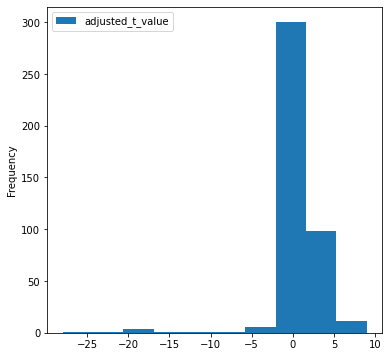

In [19]:
(
    df
    .loc[lambda x: x['adjusted_t_value'] <=10 ]
    .reindex(columns = ['adjusted_t_value'])
    .plot
    .hist(10, figsize= (6,6))
)

In [20]:
df['adjusted_t_value'].describe()

count      440.000000
mean        35.843182
std        536.716713
min        -28.000000
25%          0.000000
50%          0.000000
75%          2.000000
max      10307.000000
Name: adjusted_t_value, dtype: float64

In [21]:
df['sjr'].describe()

count    547.000000
mean       2.802090
std        2.833396
min        0.314000
25%        1.339000
50%        1.937000
75%        3.328000
max       11.193000
Name: sjr, dtype: float64

In [22]:
df.loc[lambda x: x['sjr'] == 0].head()

,publication_name,rang_digit,filters,to_remove,id,image,row_id_excel,row_id_google_spreadsheet,table_refer,incremental_id,paper_name,rank,sjr,sjr_best_quartile,h_index,total_docs_2020,total_docs_3years,total_refs,total_cites_3years,citable_docs_3years,cites_doc_2years,country,publication_year,publication_type,cnrs_ranking,peer_reviewed,study_focused_on_social_environmental_behaviour,type_of_data,first_date_of_observations,mid_year,last_date_of_observations,windows,adjusted_model_name,adjusted_model,dependent,adjusted_dependent,independent,adjusted_independent,social,environmental,governance,financial_crisis,kyoto,regions,study_focusing_on_developing_or_developed_countries,lag,interaction_term,quadratic_term,n,r2,beta,sign_of_effect,adjusted_t_value,adjusted_standard_error,target,p_value_significant,weight,nb_authors,reference_count,citation_count,cited_by_total,is_open_access,total_paper,esg,pct_esg,paper_name.1,female,male,unknown,pct_female,region_journal,csr_20_categories,cfp_4_categories,cluster_w_emb,sentiment,lenght,adj,noun,verb,size_abstract,pct_adj,pct_noun,pct_verb,d_female,providers,d_rang_digit


## Validation text

"our final database includes 588 studies, divided into 51 journals, 90 titles and 87 different first authors. It is therefore important to note that, among all the studies ultimately selected for our study, 38% of the observations are concentrated in 10 papers and 10 authors"

- includes 588 studies: CORRECT

In [23]:
df.shape[0]

547

- divided into 51 journals: It should be 39

In [24]:
df['publication_name'].nunique()

37

- 90 titles: It should be 78

In [25]:
df['id'].nunique()

75

- 87 different first authors: TO CHECK

- 38% of the observations are concentrated in 10 papers: It should be 46

In [26]:
(
    (df.groupby('id')['id'].count()/df.shape[0]).rename("count")
    .reset_index()
    .sort_values(by = ['count'], ascending = False)
    .assign(cum_sum = lambda x: x['count'].cumsum())
    .reset_index()
    .drop(columns = ['index'])
    .head(10)
)

,id,count,cum_sum
0,30,0.127971,0.127971
1,10,0.065814,0.193784
2,80,0.058501,0.252285
3,11,0.036563,0.288848
4,33,0.032907,0.321755
5,82,0.029250,0.351005
6,25,0.025594,0.376600
7,24,0.025594,0.402194
8,94,0.025594,0.427788
9,17,0.021938,0.449726


In [27]:
(df.groupby('csr_20_categories')['csr_20_categories'].count())

csr_20_categories
BLOOMBERG     22
MSCI         224
OTHER        210
THOMSON       91
Name: csr_20_categories, dtype: int64

In [28]:
(df.groupby(['target','csr_20_categories'])['csr_20_categories'].count().unstack(-2))

target,NOT_SIGNIFICANT,SIGNIFICANT
csr_20_categories,,
BLOOMBERG,5,17
MSCI,119,105
OTHER,72,138
THOMSON,55,36


In [29]:
(df.groupby('providers')['providers'].count())

providers
MSCI        224
NOT_MSCI    323
Name: providers, dtype: int64

In [30]:
(df.groupby(['target','providers'])['providers'].count().unstack(-2))

target,NOT_SIGNIFICANT,SIGNIFICANT
providers,,
MSCI,119,105
NOT_MSCI,132,191


In [31]:
(df.groupby('cfp_4_categories')['cfp_4_categories'].count())

cfp_4_categories
Accounting based metrics    313
Authors own metrics           1
Market based metrics        190
Other                        43
Name: cfp_4_categories, dtype: int64

In [32]:
(df.groupby('d_female')['d_female'].count())

d_female
NO     230
YES    317
Name: d_female, dtype: int64

In [33]:
(df.groupby('target')['pct_female'].describe())

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
NOT_SIGNIFICANT,251.0,0.307437,0.271322,0.0,0.0,0.333333,0.5,1.0
SIGNIFICANT,296.0,0.277815,0.309932,0.0,0.0,0.200000,0.5,1.0


In [34]:
(df.groupby(['target','d_female'])['d_female'].count().unstack(-2))

target,NOT_SIGNIFICANT,SIGNIFICANT
d_female,,
NO,87,143
YES,164,153


In [35]:
(df.groupby('cluster_w_emb')['cluster_w_emb'].count())

cluster_w_emb
CLUSTER_0    182
CLUSTER_1    102
CLUSTER_2    263
Name: cluster_w_emb, dtype: int64

In [36]:
(df.groupby(['target','cluster_w_emb'])['cluster_w_emb'].count().unstack(-2))

target,NOT_SIGNIFICANT,SIGNIFICANT
cluster_w_emb,,
CLUSTER_0,103,79
CLUSTER_1,26,76
CLUSTER_2,122,141


In [37]:
(df.groupby('rang_digit')['publication_name'].nunique())

rang_digit
1     9
2     9
3     1
4     4
5    14
Name: publication_name, dtype: int64

In [38]:
(df.groupby('d_rang_digit')['publication_name'].nunique())

d_rang_digit
rank_1        9
rank_2345    28
Name: publication_name, dtype: int64

In [39]:
(df.groupby(['target','d_rang_digit'])['publication_name'].nunique().unstack(-2))

target,NOT_SIGNIFICANT,SIGNIFICANT
d_rang_digit,,
rank_1,5,9
rank_2345,24,24


In [40]:
df.loc[lambda x: x['rang_digit'].isin(['4'])]['publication_name'].unique()

array(['review of managerial science',
       'business strategy and the environment',
       'review of quantitative finance and accounting',
       'pacific basin finance journal'], dtype=object)

## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [41]:
add_to_dic = False
if add_to_dic:
    if os.path.exists("schema_table.json"):
        os.remove("schema_table.json")
    data = {'to_rename':[], 'to_remove':[]}
    dic_rename = [
        {
        'old':'working\_capital\_i',
        'new':'\\text{working capital}_i'
        },
    ]

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)

In [42]:
sys.path.append(os.path.join(parent_path, 'utils'))
import latex.latex_beautify as lb
#%load_ext autoreload
#%autoreload 2

In [43]:
#!conda install -c conda-forge r-lmtest -y

In [44]:
options(warn=-1)
library(tidyverse)
library("sandwich")
library("lmtest")
#library(lfe)
#library(lazyeval)
#library(nnet)
library('progress')
path = "../../../utils/latex/table_golatex.R"
source(path)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [45]:
%get df_path

normalit<-function(m){
   (m - min(m))/(max(m)-min(m))
 }
df_final <- read_csv(df_path) %>%
mutate_if(is.character, as.factor) %>%

mutate(
    sign_of_effect = relevel(sign_of_effect, ref='NEGATIVE'),
    adjusted_model = relevel(adjusted_model, ref='OTHER'),
    adjusted_dependent = relevel(adjusted_dependent, ref='OTHER'),
      id = as.factor(id),
    governance = relevel(as.factor(governance), ref = 'NO'),
    social = relevel(as.factor(social), ref = 'NO'),
    environmental =relevel(as.factor(environmental), ref = 'NO'),
    financial_crisis =relevel(as.factor(financial_crisis), ref = 'NO'),
    kyoto =relevel(as.factor(kyoto), ref = 'NO'),
    target =relevel(as.factor(target), ref = 'NOT_SIGNIFICANT'),
    study_focusing_on_developing_or_developed_countries =relevel(
        as.factor(study_focusing_on_developing_or_developed_countries), ref = 'WORLDWIDE'),
    regions =relevel(as.factor(regions), ref = 'WORLDWIDE'),
    cnrs_ranking =relevel(as.factor(cnrs_ranking), ref = '0'),
    is_open_access =relevel(as.factor(is_open_access), ref = 'NO'),
    sentiment =relevel(as.factor(sentiment), ref = 'NEGATIVE'),
    region_journal =relevel(as.factor(region_journal), ref = 'NORTHERN AMERICA'),
    csr_20_categories =relevel(as.factor(csr_20_categories), ref = 'OTHER'),
    pct_esg_1 = normalit(pct_esg),
    esg_1 =  normalit(esg),
    sjr_1 =  normalit(sjr),
    cluster_w_emb = relevel(as.factor(cluster_w_emb), ref = 'CLUSTER_1'),
    d_female = relevel(as.factor(d_female), ref = 'NO'),
    citation_count_1 = normalit(citation_count),
    providers = relevel(as.factor(providers), ref = 'NOT_MSCI'),
    d_rang_digit = relevel(as.factor(d_rang_digit), ref = 'rank_2345')
)

Parsed with column specification:
cols(
  .default = col_double(),
  publication_name = col_character(),
  filters = col_character(),
  to_remove = col_character(),
  image = col_character(),
  row_id_excel = col_character(),
  row_id_google_spreadsheet = col_character(),
  table_refer = col_character(),
  paper_name = col_character(),
  sjr_best_quartile = col_character(),
  country = col_character(),
  publication_type = col_character(),
  peer_reviewed = col_character(),
  study_focused_on_social_environmental_behaviour = col_character(),
  type_of_data = col_character(),
  adjusted_model_name = col_character(),
  adjusted_model = col_character(),
  dependent = col_character(),
  adjusted_dependent = col_character(),
  independent = col_character(),
  adjusted_independent = col_character()
  # ... with 23 more columns
)
See spec(...) for full column specifications.


In [46]:
glimpse(df_final)

Observations: 547
Variables: 91
$ X1                                                  <dbl> 0, 1, 2, 3, 4, 5,…
$ publication_name                                    <fct> technology in soc…
$ rang_digit                                          <dbl> 5, 5, 5, 5, 5, 5,…
$ filters                                             <fct> YESNONO, NOYESNO,…
$ to_remove                                           <fct> TO_KEEP, TO_KEEP,…
$ id                                                  <fct> 86, 86, 20, 10, 1…
$ image                                               <fct> https://docs.goog…
$ row_id_excel                                        <fct> https://docs.goog…
$ row_id_google_spreadsheet                           <fct> https://docs.goog…
$ table_refer                                         <fct> table 1, table 1,…
$ incremental_id                                      <dbl> 602, 603, 138, 52…
$ paper_name                                          <fct> The impact of cor…
$ rank              

In [47]:
transpose(df_final %>% 
    select_if(function(x) any(is.na(x))) %>% 
    summarise_each(funs(sum(is.na(.)))))

[[1]]
[[1]]$image
[1] 115

[[1]]$peer_reviewed
[1] 7

[[1]]$type_of_data
[1] 2

[[1]]$adjusted_independent
[1] 8

[[1]]$study_focusing_on_developing_or_developed_countries
[1] 10

[[1]]$lag
[1] 3

[[1]]$interaction_term
[1] 3

[[1]]$quadratic_term
[1] 3

[[1]]$n
[1] 6

[[1]]$r2
[1] 86

[[1]]$beta
[1] 1

[[1]]$adjusted_t_value
[1] 107

[[1]]$adjusted_standard_error
[1] 79

[[1]]$sentiment
[1] 9

[[1]]$lenght
[1] 9

[[1]]$adj
[1] 9

[[1]]$noun
[1] 9

[[1]]$verb
[1] 9

[[1]]$size_abstract
[1] 9

[[1]]$pct_adj
[1] 9

[[1]]$pct_noun
[1] 9

[[1]]$pct_verb
[1] 9

GLM does not clustered the standard error so, we compute it by hand

In [48]:
se_robust <- function(x)
  coeftest(x, vcov. = sandwich::sandwich
          )[, 2]

# Table 1: Probit

$$
\mathrm{P}\left(\text { Significant }_{\mathrm{ib}}=\mathrm{significant}\right)=\mathrm{\beta}_{0} + 
\mathrm{\beta}_{1}\text { ESG }_{\mathrm{ib}}+ 
\mathrm{\beta}_{2}\text { Kyoto }_{\mathrm{i}} +
\mathrm{\beta}_{3}\text { Financial crisis }_{\mathrm{i}} +
\mathrm{\beta}_{4}\text { Publication year }_{\mathrm{i}} + 
\mathrm{\beta}_{5}\text { windows }_{\mathrm{i}} +
\mathrm{\beta}_{6}\text { mid-year }_{\mathrm{i}} +
\mathrm{\beta}_{7}\text { region }_{\mathrm{ib}}
+\epsilon _{\mathrm{ib}}
$$

- robust standard error
- Cannot compute clustered standard error if we add features without variation among the c luster (i.e `n`, or journal information)

## Variable construction


* Significant: If in the table, p-value below .1, then significant else not significant
* The variable adjusted_independent is too imbalanced, and we are interested in only:
  * SOCIAL
  * ENVIRONMENTAL
  * GOVERNANCE
- d_rang_digit: CNRS has 4 categories, ranging from 1 to 4. We added a 5th category for the missing one. The dummy compare the top journals (rank 1) vs. the others
* So need to create three underlying dummy variables: rules below
  * Source low-level variable: https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=146632716&range=B126
  * SOCIAL if adjusted_independent : 
    * ENVIRONMENTAL AND SOCIAL
    * SOCIAL
    * CSP
    * CSR
    * ENVIRONMENTAL, SOCIAL and GOVERNANCE
  * ENVIRONMENTAL if adjusted_independent :
    * ENVIRONMENTAL
    * ENVIRONMENTAL AND SOCIAL
    * ENVIRONMENTAL, SOCIAL and GOVERNANCE
  * GOVERNANCE if adjusted_independent :
    * GOVERNANCE
    * ENVIRONMENTAL, SOCIAL and GOVERNANCE
- adjusted_model: https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=793443705&range=B34
- adjusted_dependent: https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=450174628&range=B59
- Region:
    - AFRICA: 'Cameroon', 'Egypt', 'Libya', 'Morocco', 'Nigeria'
    - ASIA AND PACIFIC:  'India', 'Indonesia', 'Taiwan', 'Vietnam', 
        'Australia', 'China', 'Iran', 'Malaysia', 
        'Pakistan', 'South Korea', 'Bangladesh'
    - EUROPE: 'Spain', '20 European countries', 
        'United Kingdom', 'France', 'Germany, Italy, the Netherlands and United Kingdom', 
        'Turkey', 'UK'
    - LATIN AMERICA: 'Latin America', 'Brazil'
    - NORTH AMERICA: 'USA', 'US', 'U.S.', 'Canada'
    - ELSE WORLDWIDE
- Kyoto first_date_of_observations >= 1997 THEN TRUE ELSE FALSE ,
- Financial crisis first_date_of_observations >= 2009 THEN TRUE ELSE FALSE 
- windows: last_date_of_observations - first_date_of_observations
- mid-year: last_date_of_observations - (windows/2)
- is_open_access: True if the journal is an open access publication
- region_journal: Region journal
    - Europe
        - Eastern Europe
        - Western Europe
    - Northern America
- providers: If `csr_20_categories` equals to 'MSCI'  then "MCSI" else "NOT_MSCI". MSCI is the main ESG's data provider
- nb_authors: Number of authors
- pct_female: Percentage of female authors
- pct_esg_1: ESG expert score calculated as the number of publications labeled as ESG over the total number of publications for all the authors of the paper
- Sentiment: Overall feeling of the abstract. Positive means the abstract tend to have more words associated with a positive connotation
- cluster_w_emb: 3 clusters computed using the words in the abstract (embeddings), the number of verbs, noun,s and adjectives but also the size of the abstract. 


## note about Probit 

TO estimate a probit, use `probit` link function.  For logistic regression, use `binomial`

- Reason Probit instead of Logit
    - [What is the Difference Between Logit and Probit Models?](https://tutorials.methodsconsultants.com/posts/what-is-the-difference-between-logit-and-probit-models/)

Logit and probit differ in how they define $f(∗)$. The logit model uses something called the cumulative distribution function of the logistic distribution. The probit model uses something called the cumulative distribution function of the standard normal distribution to define $f(∗)$.

Probit models can be generalized to account for non-constant error variances in more advanced econometric settings (known as heteroskedastic probit models)

## How to read

**Comparison group**

- Always `OTHER`
- Target: `SIGNIFICANT`
- regions: `WORLDWIDE`
- cnrs_ranking: `0`

**Odd ratio**

- Categorical:
    - Keeping all other variables constant, if the analysis uses FIXED EFFECT model, there are 2.71 times more likely to stay in the NEGATIVE sign category as compared to the OTHER model category. The coefficient, however, is not significant. (Col 1)
- Continuous:
    - Keeping all other variables constant, if the SJR score increases one unit, there is 1.003 times more likely to stay in the POSITIVE sign category as compared to the OTHER model category y (the risk or odds is .2% higher). The coefficient is significant.
    
Here, OTHER means insignificant

### Baseline table

The baseline regression accounts for: 

```
environmental # social governance
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
```

In [49]:
### Baseline SJR
t_0 <- glm(target ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers,
           data = df_final ,
           binomial(link = "probit")
          )
t_0.rrr <- exp(coef(t_0))
t_1 <- glm(target ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers,
           data = df_final , binomial(link = "probit"))
t_1.rrr <- exp(coef(t_1))
t_2 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers,
           data = df_final , binomial(link = "probit"))
t_2.rrr <- exp(coef(t_2))
### Econometrics control
t_3 <- glm(target ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final ,
           binomial(link = "probit")
          )
t_3.rrr <- exp(coef(t_3))
t_4 <- glm(target ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final , binomial(link = "probit"))
t_4.rrr <- exp(coef(t_4))
t_5 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final , binomial(link = "probit"))
t_5.rrr <- exp(coef(t_5))

list_final = list(t_0, t_1, t_2, t_3, t_4, t_5)
list_final.rrr = list(t_0.rrr,t_1.rrr ,t_2.rrr,t_3.rrr,t_4.rrr,t_5.rrr)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje",
         out="TABLES/table_0.txt")


                                                   target                        
                              (1)      (2)      (3)      (4)      (5)      (6)   
---------------------------------------------------------------------------------
environmentalYES            1.069***                   1.114***                  
                            (0.161)                    (0.167)                   
                                                                                 
socialYES                            1.038***                   1.018***         
                                     (0.149)                    (0.150)          
                                                                                 
governanceYES                                 0.820***                   0.824***
                                              (0.303)                    (0.300) 
                                                                                 
adjusted_modelD

In [50]:
### Baseline CNRS
t_0 <- glm(target ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + providers,
           data = df_final ,
           binomial(link = "probit")
          )
t_0.rrr <- exp(coef(t_0))
t_1 <- glm(target ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + providers,
           data = df_final , binomial(link = "probit"))
t_1.rrr <- exp(coef(t_1))
t_2 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + providers,
           data = df_final , binomial(link = "probit"))
t_2.rrr <- exp(coef(t_2))
### Econometrics control
t_3 <- glm(target ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + providers
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final ,
           binomial(link = "probit")
          )
t_3.rrr <- exp(coef(t_3))
t_4 <- glm(target ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + providers
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final , binomial(link = "probit"))
t_4.rrr <- exp(coef(t_4))
t_5 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + providers
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final , binomial(link = "probit"))
t_5.rrr <- exp(coef(t_5))

list_final = list(t_0, t_1, t_2, t_3, t_4, t_5)
list_final.rrr = list(t_0.rrr,t_1.rrr ,t_2.rrr,t_3.rrr,t_4.rrr,t_5.rrr)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje",
         out="TABLES/table_1.txt")


                                                   target                        
                              (1)      (2)      (3)      (4)      (5)      (6)   
---------------------------------------------------------------------------------
environmentalYES            1.085***                   1.128***                  
                            (0.159)                    (0.166)                   
                                                                                 
socialYES                            1.023***                   1.007***         
                                     (0.148)                    (0.149)          
                                                                                 
governanceYES                                 0.819***                   0.822***
                                              (0.306)                    (0.305) 
                                                                                 
adjusted_modelD

### Papers and authors specification


In the second tables, we focus on the authors informations:

Baseline variables + 

- nb_authors: Number of authors in the paper
- pct_female: Percentage of female author
- pct_esg_1: ESG expertise of the authors (normalized value)



In [51]:
###
t_0 <- glm(target ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final ,
           binomial(link = "probit")
          )
t_0.rrr <- exp(coef(t_0))


t_1 <- glm(target ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final ,
           binomial(link = "probit")
          )
t_1.rrr <- exp(coef(t_1))

t_2 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final ,
           binomial(link = "probit")
          )
t_2.rrr <- exp(coef(t_2))

list_final = list(t_0, t_1, t_2)
list_final.rrr = list(t_0.rrr,t_1.rrr,t_2.rrr)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje",
         out="TABLES/table_3.txt")


                                             target                 
                                 (1)           (2)          (3)     
--------------------------------------------------------------------
environmentalYES              1.034***                              
                               (0.163)                              
                                                                    
socialYES                                   1.083***                
                                             (0.152)                
                                                                    
governanceYES                                             0.779**   
                                                          (0.312)   
                                                                    
adjusted_modelDIFF IN DIFF     0.877*        0.895*        0.891*   
                               (0.514)       (0.515)      (0.512)   
                                 

In [52]:
###
t_0 <- glm(target ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + providers
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final ,
           binomial(link = "probit")
          )
t_0.rrr <- exp(coef(t_0))


t_1 <- glm(target ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + providers
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final ,
           binomial(link = "probit")
          )
t_1.rrr <- exp(coef(t_1))

t_2 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + providers
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final ,
           binomial(link = "probit")
          )
t_2.rrr <- exp(coef(t_2))

list_final = list(t_0, t_1, t_2)
list_final.rrr = list(t_0.rrr,t_1.rrr,t_2.rrr)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje",
         out="TABLES/table_4.txt")


                                             target                 
                                 (1)           (2)          (3)     
--------------------------------------------------------------------
environmentalYES              1.060***                              
                               (0.161)                              
                                                                    
socialYES                                   1.056***                
                                             (0.151)                
                                                                    
governanceYES                                             0.779**   
                                                          (0.317)   
                                                                    
adjusted_modelDIFF IN DIFF      0.825         0.841        0.841    
                               (0.514)       (0.515)      (0.511)   
                                 

### Characteristic abstract

**Sentiment**: Overall feeling of the abstract. Positive means the abstract tend to have more words associated with a positive connotation

**cluster_w_emb**: 3 clusters computed using the words in the abstract (embeddings), the number of verbs, noun,s and adjectives but also the size of the abstract. 

The k-mean algorithm clustered the abstract based on the "quality" of it. 

- sentiment
- cluster

![](https://storage.googleapis.com/memvp-25499.appspot.com/images/image.png76221423-1aa4-4af3-a9e0-3a6b46b0c1f2)

In [87]:
###
t_0 <- glm(target ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + sentiment
           + cluster_w_emb,
           data = df_final ,
           binomial(link = "probit")
          )
t_0.rrr <- exp(coef(t_0))


t_1 <- glm(target ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + sentiment
           + cluster_w_emb,
           data = df_final ,
           binomial(link = "probit")
          )
t_1.rrr <- exp(coef(t_1))

t_2 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + sentiment
           + cluster_w_emb,
           data = df_final ,
           binomial(link = "probit")
          )
t_2.rrr <- exp(coef(t_2))

list_final = list(t_0, t_1, t_2)
list_final.rrr = list(t_0.rrr,t_1.rrr,t_2.rrr)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje",
         out="TABLES/table_6.txt")


                                             target                 
                                 (1)           (2)          (3)     
--------------------------------------------------------------------
environmentalYES              1.054***                              
                               (0.165)                              
                                                                    
socialYES                                   1.084***                
                                             (0.151)                
                                                                    
governanceYES                                              0.655*   
                                                          (0.343)   
                                                                    
adjusted_modelDIFF IN DIFF      0.700         0.703        0.716    
                               (0.475)       (0.475)      (0.474)   
                                 

In [88]:
###
t_0 <- glm(target ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + providers
           + sentiment
           + cluster_w_emb,
           data = df_final ,
           binomial(link = "probit")
          )
t_0.rrr <- exp(coef(t_0))


t_1 <- glm(target ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + providers
           + sentiment
           + cluster_w_emb,
           data = df_final ,
           binomial(link = "probit")
          )
t_1.rrr <- exp(coef(t_1))

t_2 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + providers
           + sentiment
           + cluster_w_emb,
           data = df_final ,
           binomial(link = "probit")
          )
t_2.rrr <- exp(coef(t_2))

list_final = list(t_0, t_1, t_2)
list_final.rrr = list(t_0.rrr,t_1.rrr,t_2.rrr)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje",
         out="TABLES/ttable_5.txt")


                                             target                 
                                 (1)           (2)          (3)     
--------------------------------------------------------------------
environmentalYES              1.057***                              
                               (0.163)                              
                                                                    
socialYES                                   1.075***                
                                             (0.150)                
                                                                    
governanceYES                                              0.666*   
                                                          (0.346)   
                                                                    
adjusted_modelDIFF IN DIFF      0.756         0.760        0.772*   
                               (0.470)       (0.470)      (0.468)   
                                 

## Model OLS: 

$$
 \text{T-value}=\mathrm{\beta}_{0} + 
\mathrm{\beta}_{1}\text { ESG }_{\mathrm{ib}}+ 
\mathrm{\beta}_{2}\text { Kyoto }_{\mathrm{i}} +
\mathrm{\beta}_{3}\text { Financial crisis }_{\mathrm{i}} +
\mathrm{\beta}_{4}\text { Publication year }_{\mathrm{i}} + 
\mathrm{\beta}_{5}\text { windows }_{\mathrm{i}} +
\mathrm{\beta}_{6}\text { mid-year }_{\mathrm{i}} +
\mathrm{\beta}_{7}\text { region }_{\mathrm{ib}}
+\epsilon _{\mathrm{ib}}
$$

### Computation t-value

* construct should_t_value   equals to “TO_CHECK” → if test_standard_error   = “TO_CHECK” and adjusted_model  is not PANEL or POOLED (use panel because panel use clustered/robust standard error no direct computation), then check if switch standard error and t-stat, so use column sr has t-stat and compare with critical value. If match critical value, and equals to stars  then OK, else “TO_CHECK”
* Construct adjusted_standard_error : if test_standard_error  is OK and should_t_value  is NO_NEED_TO_CHECK then use sr , else leave blank
* Construct **adjusted_t_value**: 
  * ⚠️ critical value (the raw data has a column for the t_value which is similar, but the variable adjusted_t_value is reconstructed based on known t_value or in case of unknown t_value then from standard error or p-value: 
    * If test_t_value is equals to TO_CHECK or OK then use t_value ← We use the value reported in the paper, not the one reconstructed
    * ELSE if test_standard_error is equal to NO_SE and test_p_value is equal to OK then we can compute the critical value using the t-inverse function. 
      * Ex: round(T.INV(1-X114, I114) where X114 is the p-value, so we want to get the right tail. If p-value is .05, the the right tail is .95.
    * ELSE beta / standard error 
    * Note, if critical value cannot be computed, it is because of one of the following reason
      *  p-value is 0, then cannot compute the critical value
      * standard error is 0, cannot divide by 0
      * missing standard error, t-value or p-value
      
- Remove 10 outliers -> critical value more than 1K -> high leverage and does not represent the true data
- Standard error robust

Model 1: No absolute value

Interested in the magnitude of the t-student critical value

In [75]:
### Baseline SJR
t_0 <- glm(adjusted_t_value ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_1 <- glm(adjusted_t_value ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_2 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

### Econometrics control
t_3 <- glm(adjusted_t_value ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_4 <- glm(adjusted_t_value ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_5 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))


list_final = list(t_0, t_1, t_2, t_3, t_4, t_5)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          style = "qje")


                                                    adjusted_t_value                         
                               (1)        (2)        (3)        (4)        (5)        (6)    
---------------------------------------------------------------------------------------------
environmentalYES             1.321***                         1.323***                       
                             (0.328)                          (0.339)                        
                                                                                             
socialYES                              -1.184***                        -1.208***            
                                        (0.276)                          (0.289)             
                                                                                             
governanceYES                                       -0.443                           -0.431  
                                                   (0.598) 

In [77]:
### Baseline SJR
t_0 <- glm(adjusted_t_value ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_1 <- glm(adjusted_t_value ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_2 <- glm(adjusted_t_value ~ governance
            + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

### Econometrics control
t_3 <- glm(adjusted_t_value ~ environmental
            + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_4 <- glm(adjusted_t_value ~ social
            + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_5 <- glm(adjusted_t_value ~ governance
            + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))


list_final = list(t_0, t_1, t_2, t_3, t_4, t_5)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          style = "qje")


                                                    adjusted_t_value                         
                               (1)        (2)        (3)        (4)        (5)        (6)    
---------------------------------------------------------------------------------------------
environmentalYES             1.255***                         1.279***                       
                             (0.334)                          (0.344)                        
                                                                                             
socialYES                              -1.122***                        -1.178***            
                                        (0.279)                          (0.292)             
                                                                                             
governanceYES                                       -0.463                           -0.441  
                                                   (0.593) 

Author

In [78]:
###
t_0 <- glm(adjusted_t_value ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )
t_1 <- glm(adjusted_t_value ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

t_2 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

list_final = list(t_0, t_1, t_2)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          style = "qje")


                                        adjusted_t_value            
                                 (1)           (2)          (3)     
--------------------------------------------------------------------
environmentalYES              1.178***                              
                               (0.311)                              
                                                                    
socialYES                                   -0.987***               
                                             (0.243)                
                                                                    
governanceYES                                              -0.787   
                                                          (0.593)   
                                                                    
adjusted_modelFIXED EFFECT     -0.446        -0.231        -0.148   
                               (0.429)       (0.411)      (0.427)   
                                 

In [79]:
###
t_0 <- glm(adjusted_t_value ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )
t_1 <- glm(adjusted_t_value ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

t_2 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

list_final = list(t_0, t_1, t_2)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          style = "qje")


                                        adjusted_t_value            
                                 (1)           (2)          (3)     
--------------------------------------------------------------------
environmentalYES              1.092***                              
                               (0.315)                              
                                                                    
socialYES                                   -0.934***               
                                             (0.248)                
                                                                    
governanceYES                                              -0.760   
                                                          (0.594)   
                                                                    
adjusted_modelFIXED EFFECT     -0.174         0.023        0.075    
                               (0.430)       (0.414)      (0.431)   
                                 

Abstract

In [80]:
###
t_0 <- glm(adjusted_t_value ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + sentiment
           + cluster_w_emb,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )
t_1 <- glm(adjusted_t_value ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + sentiment
           + cluster_w_emb,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

t_2 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + sentiment
           + cluster_w_emb,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

list_final = list(t_0, t_1, t_2)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          style = "qje")


                                        adjusted_t_value            
                                 (1)           (2)          (3)     
--------------------------------------------------------------------
environmentalYES              1.159***                              
                               (0.277)                              
                                                                    
socialYES                                   -1.101***               
                                             (0.255)                
                                                                    
governanceYES                                              -0.331   
                                                          (0.589)   
                                                                    
adjusted_modelFIXED EFFECT    -0.907**       -0.731*       -0.623   
                               (0.409)       (0.393)      (0.412)   
                                 

In [81]:
###
t_0 <- glm(adjusted_t_value ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + sentiment
           + cluster_w_emb,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )
t_1 <- glm(adjusted_t_value ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + sentiment
           + cluster_w_emb,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

t_2 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + sentiment
           + cluster_w_emb,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

list_final = list(t_0, t_1, t_2)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          style = "qje")


                                        adjusted_t_value            
                                 (1)           (2)          (3)     
--------------------------------------------------------------------
environmentalYES              1.023***                              
                               (0.279)                              
                                                                    
socialYES                                   -0.997***               
                                             (0.253)                
                                                                    
governanceYES                                              -0.316   
                                                          (0.587)   
                                                                    
adjusted_modelFIXED EFFECT     -0.410        -0.254        -0.166   
                               (0.417)       (0.404)      (0.428)   
                                 

# Statistics

## Target


In [60]:
pd.concat(
    [
        pd.concat(
            [
                (
                    pd.concat(
                        [
                            (
                                df.groupby("environmental")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "environment"}),
                            (
                                df.groupby("social")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "social"}),
                            (
                                df.groupby("governance")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "governance"}),
                        ],
                        axis=1,
                    )
                    .T.reset_index()
                    .rename(columns={"environmental": "is_dummy", "level_0": "origin"})
                    .set_index(["origin", "is_dummy"])
                    .assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    pd.concat(
                        [
                            (
                                df.groupby(["environmental", "target"])
                                .agg({"id": "nunique"})
                                .rename(columns={"id": "environment"})
                                .unstack(0)
                            ),
                            (
                                df.groupby(["social", "target"])
                                .agg({"id": "nunique"})
                                .rename(columns={"id": "social"})
                                .unstack(0)
                            ),
                            (
                                df.groupby(["governance", "target"])
                                .agg({"id": "nunique"})
                                .rename(columns={"id": "governance"})
                                .unstack(0)
                            ),
                        ],
                        axis=1,
                    )
                    .T.reset_index()
                    .rename(columns={"environmental": "is_dummy", "level_0": "origin"})
                    .set_index(["origin", "is_dummy"])
                    .assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                              \
target               NOT_SIGNIFICANT SIGNIFICANT pct_significant   
origin      is_dummy                                               
environment NO                   199         235        0.541475   
            YES                   52          61        0.539823   
social      NO                    76          84        0.525000   
            YES                  175         212        0.547804   
governance  NO                   234         285        0.549133   
            YES                   17          11        0.392857   

                         paper count                              
target               NOT_SIGNIFICANT SIGNIFICANT pct_significant  
origin      is_dummy                                              
environment NO                    41          60        0.594059  
            YES                   14          18        0.562500  
social      NO                    18          24        0.571429  
            YES                   37          56        0.602151  
governance  NO                    45          66        0.594595  
            YES                    4           4        0.500000

In [61]:
pd.concat(
    [
        pd.concat(
            [
                (
                    df.groupby("adjusted_model")
                    .agg({"target": "value_counts"})
                    .unstack(-1)
                    .assign(
                        pct_significant=lambda x: x[("target", "SIGNIFICANT")]
                        / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    df.groupby(["adjusted_model", "target"])
                    .agg({"id": "nunique"})
                    .rename(columns={"id": "adjusted_model"})
                    .unstack(-1)
                    .assign(
                        pct_significant=lambda x: x[("adjusted_model", "SIGNIFICANT")]
                        / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                                 paper count  \
                        target             pct_significant  adjusted_model   
target         NOT_SIGNIFICANT SIGNIFICANT                 NOT_SIGNIFICANT   
adjusted_model                                                               
DIFF IN DIFF                 8           4        0.333333               1   
FIXED EFFECT                98         131        0.572052              17   
INSTRUMENT                   9           7        0.437500               5   
LAG DEPENDENT               34           8        0.190476               2   
OTHER                       34          45        0.569620              12   
POOLED OLS                  59          78        0.569343              13   
RANDOM EFFECT                9          23        0.718750               6   

                                            
                           pct_significant  
target         SIGNIFICANT                  
adjusted_model                              
DIFF IN DIFF             1        0.500000  
FIXED EFFECT            26        0.604651  
INSTRUMENT               5        0.500000  
LAG DEPENDENT            3        0.600000  
OTHER                   14        0.538462  
POOLED OLS              20        0.606061  
RANDOM EFFECT            8        0.571429

In [62]:
(
    pd.concat(
        [
            (df.groupby("kyoto").agg({"target": "value_counts"}).unstack(0)).rename(columns = {'target':'kyoto'}),
            (df.groupby("financial_crisis").agg({"target": "value_counts"}).unstack(0)).rename(columns = {'target':'financial_crisis'}),
        ],
        axis=1,
    )
    .T
    .reset_index()
    .rename(columns = {'kyoto':'is_dummy', 'level_0':'origin'})
    .set_index(['origin','is_dummy'])
    .assign(pct_significant = lambda x: x[('SIGNIFICANT')]/x.sum(axis= 1))
)

target                     NOT_SIGNIFICANT  SIGNIFICANT  pct_significant
origin           is_dummy                                               
kyoto            NO                     65           65         0.500000
                 YES                   186          231         0.553957
financial_crisis NO                    241          240         0.498960
                 YES                    10           56         0.848485

In [63]:
pd.concat(
    [
        pd.concat(
            [
                (
                    pd.concat(
                        [
                            (
                                df.groupby("kyoto")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "kyoto"}),
                            (
                                df.groupby("financial_crisis")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "financial_crisis"}),
                        ],
                        axis=1,
                    )
                    .T.reset_index()
                    .rename(columns={"kyoto": "is_dummy", "level_0": "origin"})
                    .set_index(["origin", "is_dummy"])
                    .assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    pd.concat(
                        [
                            (
                                df.groupby(["kyoto", "target"])
                                .agg({"id": "nunique"})
                                .rename(columns={"id": "kyoto"})
                                .unstack(0)
                            ),
                            (
                                df.groupby(["financial_crisis", "target"])
                                .agg({"id": "nunique"})
                                .rename(columns={"id": "financial_crisis"})
                                .unstack(0)
                            ),
                        ],
                        axis=1,
                    )
                    .T.reset_index()
                    .rename(columns={"kyoto": "is_dummy", "level_0": "origin"})
                    .set_index(["origin", "is_dummy"])
                    .assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                              \
target                    NOT_SIGNIFICANT SIGNIFICANT pct_significant   
origin           is_dummy                                               
kyoto            NO                    65          65        0.500000   
                 YES                  186         231        0.553957   
financial_crisis NO                   241         240        0.498960   
                 YES                   10          56        0.848485   

                              paper count                              
target                    NOT_SIGNIFICANT SIGNIFICANT pct_significant  
origin           is_dummy                                              
kyoto            NO                    14          18        0.562500  
                 YES                   33          50        0.602410  
financial_crisis NO                    43          56        0.565657  
                 YES                    4          12        0.750000

## Papers

In [64]:
(
    df
    .groupby('target')
    .agg(
    {
        'windows':'describe'
    })
)

windows                                               
                  count      mean       std  min  25%  50%   75%   max
target                                                                
NOT_SIGNIFICANT   251.0  8.840637  4.653440  0.0  5.0  9.0  13.0  28.0
SIGNIFICANT       296.0  7.652027  4.642164  0.0  4.0  6.0  10.0  28.0

- lag
- interaction_term
- quadratic_term

In [65]:
(
    pd.concat(
        [
            (df.groupby("lag").agg({"target": "value_counts"}).unstack(0)).rename(columns = {'target':'lag'}),
            (df.groupby("interaction_term").agg({"target": "value_counts"}).unstack(0)).rename(columns = {'target':'interaction_term'}),
            (df.groupby("quadratic_term").agg({"target": "value_counts"}).unstack(0)).rename(columns = {'target':'quadratic_term'}),
        ],
        axis=1,
    )
    .T
    .reset_index()
    .rename(columns = {'lag':'is_dummy', 'level_0':'origin'})
    .set_index(['origin','is_dummy'])
    .assign(pct_significant = lambda x: x[('SIGNIFICANT')]/x.sum(axis= 1))
)

target                     NOT_SIGNIFICANT  SIGNIFICANT  pct_significant
origin           is_dummy                                               
lag              NO                    196          251         0.561521
                 YES                    55           42         0.432990
interaction_term NO                    197          250         0.559284
                 NO                     31            4         0.114286
                 YES                    23           39         0.629032
quadratic_term   NO                    246          284         0.535849
                 YES                     5            9         0.642857

In [66]:
pd.concat(
    [
        pd.concat(
            [
                (
                    pd.concat(
                        [
                            (
                                df.groupby("lag")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "lag"}),
                            (
                                df.groupby("interaction_term")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "interaction_term"}),
                            (
                                df.groupby("quadratic_term")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "quadratic_term"}),
                        ],
                        axis=1,
                    )
                    .T.reset_index()
                    .rename(columns={"lag": "is_dummy", "level_0": "origin"})
                    .set_index(["origin", "is_dummy"])
                    .assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    pd.concat(
                        [
                            (
                                df.groupby(["lag", "target"])
                                .agg({"id": "nunique"})
                                .rename(columns={"id": "lag"})
                                .unstack(0)
                            ),
                            (
                                df.groupby(["interaction_term", "target"])
                                .agg({"id": "nunique"})
                                .rename(columns={"id": "interaction_term"})
                                .unstack(0)
                            ),
                            (
                                df.groupby(["quadratic_term", "target"])
                                .agg({"id": "nunique"})
                                .rename(columns={"id": "quadratic_term"})
                                .unstack(0)
                            ),
                        ],
                        axis=1,
                    )
                    .T.reset_index()
                    .rename(columns={"lag": "is_dummy", "level_0": "origin"})
                    .set_index(["origin", "is_dummy"])
                    .assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                              \
target                    NOT_SIGNIFICANT SIGNIFICANT pct_significant   
origin           is_dummy                                               
lag              NO                   196         251        0.561521   
                 YES                   55          42        0.432990   
interaction_term NO                   197         250        0.559284   
                 NO                    31           4        0.114286   
                 YES                   23          39        0.629032   
quadratic_term   NO                   246         284        0.535849   
                 YES                    5           9        0.642857   

                              paper count                              
target                    NOT_SIGNIFICANT SIGNIFICANT pct_significant  
origin           is_dummy                                              
lag              NO                    41          57        0.581633  
                 YES                   11          14        0.560000  
interaction_term NO                    45          65        0.590909  
                 NO                     1           1        0.500000  
                 YES                    8           9        0.529412  
quadratic_term   NO                    47          66        0.584071  
                 YES                    2           4        0.666667

##  Region

- regions
- study_focusing_on_developing_or_developed_countries

Comparison group: "WORLDWIDE"

In [67]:
pd.concat(
    [
        pd.concat(
            [
                (
                    df.groupby("regions")
                    .agg({"target": "value_counts"})
                    .unstack(-1)
                    .assign(
                        pct_significant=lambda x: x[("target", "SIGNIFICANT")]
                        / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    df.groupby(["regions", "target"])
                    .agg({"id": "nunique"})
                    .rename(columns={"id": "regions"})
                    .unstack(-1)
                    .assign(
                        pct_significant=lambda x: x[("regions", "SIGNIFICANT")]
                        / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                                 paper count  \
                          target             pct_significant         regions   
target           NOT_SIGNIFICANT SIGNIFICANT                 NOT_SIGNIFICANT   
regions                                                                        
AFRICA                         4           3        0.428571               1   
ASIA AND PACIFIC              33          51        0.607143              10   
EUROPE                         5          14        0.736842               1   
LATIN AMERICA                  7          13        0.650000               2   
NORTH AMERICA                 46          74        0.616667              14   
WORLDWIDE                    156         141        0.474747              19   

                                              
                             pct_significant  
target           SIGNIFICANT                  
regions                                       
AFRICA                     1        0.500000  
ASIA AND PACIFIC          13        0.565217  
EUROPE                     5        0.833333  
LATIN AMERICA              2        0.500000  
NORTH AMERICA             22        0.611111  
WORLDWIDE                 25        0.568182

## Journal

- sjr 
- sjr_best_quartile: Q1
- cnrs_ranking: 0
- h_index

In [68]:
(
    df
    .groupby('target')
    .agg(
    {
        'sjr':'describe'
    })
    #.unstack(-1)
    #.assign(pct_significant = lambda x: x[('target','SIGNIFICANT')]/x.sum(axis= 1))
)

sjr                                                        
                 count      mean       std    min    25%    50%    75%     max
target                                                                        
NOT_SIGNIFICANT  251.0  2.782880  2.649315  0.327  1.339  2.049  3.328  11.193
SIGNIFICANT      296.0  2.818378  2.984975  0.314  1.339  1.937  2.983  11.193

In [83]:
pd.concat(
    [
        pd.concat(
            [
                (
                    df.groupby("d_rang_digit")
                    .agg({"target": "value_counts"})
                    .unstack(-1)
                    .assign(
                        pct_significant=lambda x: x[("target", "SIGNIFICANT")]
                        / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    df.groupby(["d_rang_digit", "target"])
                    .agg({"id": "nunique"})
                    .rename(columns={"id": "d_rang_digit"})
                    .unstack(-1)
                    .assign(
                        pct_significant=lambda x: x[("d_rang_digit", "SIGNIFICANT")]
                        / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                                 paper count  \
                      target             pct_significant    d_rang_digit   
target       NOT_SIGNIFICANT SIGNIFICANT                 NOT_SIGNIFICANT   
d_rang_digit                                                               
rank_1                    29          53        0.646341              12   
rank_2345                222         243        0.522581              35   

                                          
                         pct_significant  
target       SIGNIFICANT                  
d_rang_digit                              
rank_1                20        0.625000  
rank_2345             48        0.578313

In [84]:
(
    df
    .groupby('target')
    .agg(
    {
        'h_index':'describe'
    })
    #.unstack(-1)
    #.assign(pct_significant = lambda x: x[('target','SIGNIFICANT')]/x.sum(axis= 1))
)

h_index                                                   \
                  count        mean        std   min   25%    50%    75%   
target                                                                     
NOT_SIGNIFICANT   251.0  137.127490  77.941001  17.0  73.0  122.0  199.0   
SIGNIFICANT       296.0  135.773649  82.835386  16.0  68.0  105.0  199.0   

                        
                   max  
target                  
NOT_SIGNIFICANT  318.0  
SIGNIFICANT      318.0

# Generate reports

In [71]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp
import sys
path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)
sys.path.append(os.path.join(parent_path, 'utils'))
import make_toc
import create_report

In [72]:
name_json = 'parameters_ETL_esg_metadata.json'
path_json = os.path.join(str(Path(path).parent.parent), 'utils',name_json)

In [85]:
create_report.create_report(extension = "html", keep_code = True, notebookname = "00_sign_of_effect_classification.ipynb")

Report Available at this adress:
 /home/ubuntu/esg_metadata/02_data_analysis/01_model_train_evaluate/01_sign_of_effect/Reports/00_sign_of_effect_classification.html


In [86]:
### Update TOC in Github
for p in [parent_path,
          str(Path(path).parent),
          #os.path.join(str(Path(path).parent), "00_download_data_from"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "00_statistical_exploration"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "01_model_estimation"),
         ]:
    try:
        os.remove(os.path.join(p, 'README.md'))
    except:
        pass
    path_parameter = os.path.join(parent_path,'utils', name_json)
    md_lines =  make_toc.create_index(cwd = p, path_parameter = path_parameter)
    md_out_fn = os.path.join(p,'README.md')
    
    if p == parent_path:
    
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = True, path_parameter = path_parameter)
    else:
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = False)